<img align="center" style="max-width: 900px; height: auto" src="./banner.png">

<img align='right' style='max-width: 200px; height: auto' src='hsg_logo.png'>

## Lab 08 - Generative Pretrained Transformer (GPT) Networks

GSERM Summer School 2024, Deep Learning: Fundamentals and Applications, University of St. Gallen

The lab environment is based on Jupyter Notebooks (https://jupyter.org), which provide an interactive platform for performing a variety of statistical evaluations and data analyses. In this lab, we will learn how to apply a deep learning technique referred to as **Generative Pre-trained Transformer (GPT)** models. Unlike standard feedforward neural networks, GPT models leverage the transformer architecture to capture long-range dependencies in sequential data, making them highly effective for natural language processing tasks.

GPT models, introduced by *OpenAI*, have revolutionized the field of NLP by achieving state-of-the-art results in text generation, translation, and summarization. The key innovation in GPT models is the use of the transformer architecture, specifically focusing on the decoder part. This architecture utilizes multi-head self-attention mechanisms and feedforward neural networks to process and generate text. In this lab, we will use the `PyTorch` library to implement and train a **GPT model**. The model will be trained on the **Tiny Shakespeare dataset**, which consists of **40,000 lines of text from various plays by Shakespeare**. Once the model is trained, we will evaluate its performance by generating new text based on given prompts and visualizing the attention mechanisms that the model uses to generate this text.

The figure below illustrates a high-level view of the machine learning process we aim to establish in this lab:

<img align="center" style="max-width: 900px" src="./prediction.png">

As always, pls. don't hesitate to ask all your questions either during the lab, post them in our CANVAS (StudyNet) forum (https://learning.unisg.ch), or send us an email (using the course email).

## 1. Lab Objectives

After today's lab, you should be able to:

> 1. **Understand the Generative Pre-trained Transformer (GPT) Design:** Learn the fundamental concepts and architectural design of GPT models.
> 2. **Implement and Train a GPT Model:** Gain hands-on experience with PyTorch to implement, train, and evaluate GPT models.
> 3. **Apply GPT Models for Text Generation:** Use GPT models to generate contextually relevant text based on given prompts.
> 4. **Evaluate and Interpret Model Performance:** Evaluate the GPT model's performance using relevant metrics and interpret the generated text results.
> 5. **Visualize and Interpret Attention Mechanisms:** Visualize the attention mechanisms to gain insights into how the model attends to the input text.

## 2. Setup of the Jupyter Notebook Environment

Similar to the previous labs, we need to import several Python libraries that facilitate data analysis and visualization. We will primarily use `PyTorch`, `NumPy`, `Matplotlib`, and a few utility libraries throughout this lab:

In [1]:
# import standard python libraries
import io
import os
import urllib
import math
import numpy as np
from tqdm import tqdm
from datetime import datetime
from urllib.request import urlopen

Import `Python` machine learning and deep learning libraries:

In [2]:
# import the PyTorch deep learning library
import torch, torchvision
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

Import `Matplotlib` and `Seaborn` data visualization libraries:

In [3]:
# import matplotlib and seaborn data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

Enable inline plotting with `Matplotlib`:

In [4]:
%matplotlib inline

Ignore potential library warnings:

In [5]:
import warnings
warnings.filterwarnings('ignore')

Create a structure of notebook sub-directories inside of the current **working directory** to store the data and the trained neural network models:

In [6]:
# create the data sub-directory
data_directory = './data_shakespeare'
if not os.path.exists(data_directory): os.makedirs(data_directory)

# create the models sub-directory
models_directory = './models_shakespeare'
if not os.path.exists(models_directory): os.makedirs(models_directory) 

Set a random `seed` value to obtain reproducible results:

In [7]:
# init deterministic seed
seed_value = 1234
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value); # set pytorch seed CPU

Google Colab provides free GPUs for running notebooks. However, if you execute this notebook as is, it will use your device's CPU. To run the lab on a GPU, go to `Runtime` > `Change runtime type` and set the Runtime type to `GPU` in the drop-down menu. Running this lab on a CPU is fine, but you will find that GPU computing is faster. *CUDA* indicates that the lab is being run on a GPU.

Enable GPU computing by setting the device flag and initializing a CUDA seed:

In [8]:
# set cpu or gpu enabled device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

# init deterministic GPU seed
torch.cuda.manual_seed(seed_value)

# log type of device enabled
print('[LOG] notebook with {} computation enabled'.format(str(device)))

[LOG] notebook with cpu computation enabled


Let's determine if we have access to a GPU provided by environments such as `Google Colab`:

In [9]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


## 3. Dataset Download and Assessment

In this section of the lab notebook, we will download and access the Tiny Shakespeare dataset. This dataset is instrumental for training our GPT model, allowing us to **generate text** in the **distinctive style of Shakespearean English**. 

### 3.1 Dataset Download

In this section of the lab notebook, we will download and access the **Tiny Shakespeare** dataset. This dataset consists of **40,000 lines from a variety of Shakespeare's plays**. We will use this dataset to train our GPT model to generate text in the style of Shakespeare. As featured in Andrej Karpathy's blog post *The Unreasonable Effectiveness of Recurrent Neural Networks*: http://karpathy.github.io/2015/05/21/rnn-effectiveness/.

<img align="center" style="max-width: 400px" src="./shakespeare.png">

Let's start by downloading the dataset and inspecting its contents. The dataset is available as a plain text file from a public URL. We will read the content of the file and decode it to a string format.

In [10]:
# download the tiny_shakespeare dataset
url = 'https://raw.githubusercontent.com/HSG-AIML-Teaching/GSERM2024-Lab/master/lab_08/01_data/tiny_shakespeare_dataset.txt'
text = urlopen(url).read().decode('utf-8')

### 3.2 Dataset Assessment

Let's print the first 400 characters of the dataset to get an initial look at the content. This will help us understand the structure of the text data we will be working with.

In [11]:
print(text[:400])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it 


We can observe that the dataset provides a rich set of language patterns and vocabulary, making it ideal for training language models like the **Generative Pretrained Transformer (GPT)**.

## 4. Dataset Pre-Processing

In this section, we will first split the tiny Shakespeare dataset into training and evaluation sets. Following, we will create a dataset from the text by converting it into a set of sequences of `n` characters each. These sequences will be used to train our GPT model. Each sequence will help the model learn to predict the next character based on the previous `n` characters.


### 4.1 Conduct Train-Test Split

We will now split the dataset into training and evaluation sets. We will use **90% of the text for training** our GPT model and the remaining **10% for evaluating** its performance. This split will help us to both train the model and assess its ability to generalize to unseen data.


In [12]:
# set the fraction of the training set to 90% of the original dataset
total_raw_chars = len(text)
train_text = text[:int(total_raw_chars * 0.9)]  # 90% of the text for training
eval_text = text[int(total_raw_chars * 0.9):]  # 10% of the text for evaluation

Next, let's inspect the number of training and evaluation characters:

In [13]:
# print the length of the training and evaluation sets
print(f'Training set: {len(train_text)} characters')
print(f'Evaluation set: {len(eval_text)} characters')

Training set: 1003853 characters
Evaluation set: 111540 characters


### 4.2 Transform Dataset into Sequences

Next, we will transform our text dataset into a format that can be processed by our GPT model. Specifically, we will map each character in the text to a unique integer and vice versa. This step is crucial for converting textual data into numerical data with which the model can work.

First, we **identify all unique characters** in the text. We also add a **special character '#'** that we will use to signify the end of a sentence.

In [14]:
# create a list of unique characters in the text and add '#' as an end-of-sentence indicator
chars = ['#'] + sorted(list(set(text)))
print(f'Unique characters: {chars}')

Unique characters: ['#', '\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Second, we understand how the data looks and how to prepare it for training. Since neural networks cannot directly work with characters, we need to convert each character in the dataset to a unique identifier. To achieve this, we will create two mapping tables:

- **`char_to_int`**: Maps each character to a unique integer.
- **`int_to_char`**: Maps each integer back to its corresponding character.

These mappings will allow us to convert the text data into a numerical format that can be processed by our GPT model.

<img align='center' style='max-width: 800px' src='character_mapping.gif'>

Let's create the mapping tables accordingly:

In [15]:
# create mappings from characters to integers and from integers to characters

# character to integer
char_to_int = {c: i for i, c in enumerate(chars)}
print(f'Character to integer mapping: {char_to_int}')

# integer to character
int_to_char = {i: c for i, c in enumerate(chars)}
print(f'Integer to character mapping: {int_to_char}')

Character to integer mapping: {'#': 0, '\n': 1, ' ': 2, '!': 3, '$': 4, '&': 5, "'": 6, ',': 7, '-': 8, '.': 9, '3': 10, ':': 11, ';': 12, '?': 13, 'A': 14, 'B': 15, 'C': 16, 'D': 17, 'E': 18, 'F': 19, 'G': 20, 'H': 21, 'I': 22, 'J': 23, 'K': 24, 'L': 25, 'M': 26, 'N': 27, 'O': 28, 'P': 29, 'Q': 30, 'R': 31, 'S': 32, 'T': 33, 'U': 34, 'V': 35, 'W': 36, 'X': 37, 'Y': 38, 'Z': 39, 'a': 40, 'b': 41, 'c': 42, 'd': 43, 'e': 44, 'f': 45, 'g': 46, 'h': 47, 'i': 48, 'j': 49, 'k': 50, 'l': 51, 'm': 52, 'n': 53, 'o': 54, 'p': 55, 'q': 56, 'r': 57, 's': 58, 't': 59, 'u': 60, 'v': 61, 'w': 62, 'x': 63, 'y': 64, 'z': 65}
Integer to character mapping: {0: '#', 1: '\n', 2: ' ', 3: '!', 4: '$', 5: '&', 6: "'", 7: ',', 8: '-', 9: '.', 10: '3', 11: ':', 12: ';', 13: '?', 14: 'A', 15: 'B', 16: 'C', 17: 'D', 18: 'E', 19: 'F', 20: 'G', 21: 'H', 22: 'I', 23: 'J', 24: 'K', 25: 'L', 26: 'M', 27: 'N', 28: 'O', 29: 'P', 30: 'Q', 31: 'R', 32: 'S', 33: 'T', 34: 'U', 35: 'V', 36: 'W', 37: 'X', 38: 'Y', 39: 'Z', 40

Third, we calculate the vocabulary size, which is the total number of unique characters including our special end-of-sentence character.

In [16]:
# determine the vocabulary size
vocab_size = len(chars)  # How many unique characters are in the text?
print(f'Vocabulary size: {vocab_size}')

Vocabulary size: 66


Next, we specify the training sequence length, which determines how many characters long each training sample should be. This parameter is crucial because the model will learn to predict the next character based on the previous `seq_length` characters. For our GPT model, we will set the `seq_length` to 100, meaning each training sample will consist of 100 characters from the text of the **Tiny Shakespeare** dataset.

In [17]:
# how long is the sequence that we want to retrieve from the dataset?
seq_length = 100

Now let's build our **ShakespeareDataset** class. This class will be responsible for providing the data samples and their corresponding targets to the model during training. The **ShakespeareDataset** class is very similar to the one used in the LSTM lab session, but here it is tailored to work with sequences of text.

In [18]:
# define the ShakespeareDataset class
class ShakespeareDataset(Dataset):

    # init dataset class
    def __init__(self, text_list, seq_length):
        
        # text_list: text to be used for training or evaluation
        # seq_length: length of the sequence we want to retrieve from the dataset
        self.text = text_list
        self.seq_length = seq_length

    # define dataset length
    def __len__(self):
        
        # return the total number of sequences that the dataset includes
        return len(self.text) - self.seq_length

    # define dataset getitem
    def __getitem__(self, index):
        
        # retrieve a random substring and its corresponding target
        sequence = self.text[index:index + self.seq_length + 1]
        target = self.text[index + 1:index + self.seq_length + 1] + '#'
        
        # convert characters of sequence and target to integers
        sequence_tensor = torch.tensor([char_to_int[c] for c in sequence], dtype=torch.long)
        target_tensor = torch.tensor([char_to_int[c] for c in target], dtype=torch.long)

        # return sequence and target tensor
        return sequence_tensor, target_tensor

The input sequence is a substring of a specified length, starting at a given index within the text. The target sequence, which is the same length as the input sequence, begins one character after the input sequence. This one-character offset is essential because it trains the model to predict the next character in the sequence. For example, if the input sequence is `To be, or not to be`, the corresponding target sequence would be `o be, or not to be#`, with the `#` character indicating the end of the sequence. Both the input sequence and the target sequence are converted from characters to their respective integer representations using the `char_to_int` mapping.

<img align='center' style='max-width: 800px' src='sequence_structure.png'>

We will now create the **training** and **evaluation datasets** using the `ShakespeareDataset` class:

In [19]:
train_dataset = ShakespeareDataset(text_list=train_text, seq_length=seq_length)
eval_dataset = ShakespeareDataset(text_list=eval_text, seq_length=seq_length)

Let's see how it works by getting the 42nd **training** sequence and its corresponding targets:

In [20]:
train_dataset.__getitem__(42)

(tensor([44, 57,  7,  2, 47, 44, 40, 57,  2, 52, 44,  2, 58, 55, 44, 40, 50,  9,
          1,  1, 14, 51, 51, 11,  1, 32, 55, 44, 40, 50,  7,  2, 58, 55, 44, 40,
         50,  9,  1,  1, 19, 48, 57, 58, 59,  2, 16, 48, 59, 48, 65, 44, 53, 11,
          1, 38, 54, 60,  2, 40, 57, 44,  2, 40, 51, 51,  2, 57, 44, 58, 54, 51,
         61, 44, 43,  2, 57, 40, 59, 47, 44, 57,  2, 59, 54,  2, 43, 48, 44,  2,
         59, 47, 40, 53,  2, 59, 54,  2, 45, 40, 52]),
 tensor([57,  7,  2, 47, 44, 40, 57,  2, 52, 44,  2, 58, 55, 44, 40, 50,  9,  1,
          1, 14, 51, 51, 11,  1, 32, 55, 44, 40, 50,  7,  2, 58, 55, 44, 40, 50,
          9,  1,  1, 19, 48, 57, 58, 59,  2, 16, 48, 59, 48, 65, 44, 53, 11,  1,
         38, 54, 60,  2, 40, 57, 44,  2, 40, 51, 51,  2, 57, 44, 58, 54, 51, 61,
         44, 43,  2, 57, 40, 59, 47, 44, 57,  2, 59, 54,  2, 43, 48, 44,  2, 59,
         47, 40, 53,  2, 59, 54,  2, 45, 40, 52,  0]))

And by getting the 42nd **evaluation** sequence and its corresponding targets:

In [21]:
eval_dataset.__getitem__(42)

(tensor([40,  9,  1,  1, 15, 14, 29, 33, 22, 32, 33, 14, 11,  1, 20, 54, 54, 43,
          2, 52, 54, 57, 57, 54, 62,  7,  2, 53, 44, 48, 46, 47, 41, 54, 60, 57,
          2, 20, 57, 44, 52, 48, 54,  9,  1, 20, 54, 43,  2, 58, 40, 61, 44,  2,
         64, 54, 60,  7,  2, 46, 44, 53, 59, 51, 44, 52, 44, 53,  3,  1,  1, 29,
         18, 33, 31, 34, 16, 21, 22, 28, 11,  1, 14, 53, 43,  2, 64, 54, 60,  7,
          2, 46, 54, 54, 43,  2, 58, 48, 57,  3,  2]),
 tensor([ 9,  1,  1, 15, 14, 29, 33, 22, 32, 33, 14, 11,  1, 20, 54, 54, 43,  2,
         52, 54, 57, 57, 54, 62,  7,  2, 53, 44, 48, 46, 47, 41, 54, 60, 57,  2,
         20, 57, 44, 52, 48, 54,  9,  1, 20, 54, 43,  2, 58, 40, 61, 44,  2, 64,
         54, 60,  7,  2, 46, 44, 53, 59, 51, 44, 52, 44, 53,  3,  1,  1, 29, 18,
         33, 31, 34, 16, 21, 22, 28, 11,  1, 14, 53, 43,  2, 64, 54, 60,  7,  2,
         46, 54, 54, 43,  2, 58, 48, 57,  3,  2,  0]))

## 5. Neural Network Implementation

In this section, we will implement the GPT architecture for the text generation model. Furthermore, we will specify the loss function, learning rate, and optimization technique to be used during the training of the network.

### 5.1. Implementation of the Network Architecture

First, we will implement the architecture of the GPT neural network used to generate text based on the given input sequences. The neural network, which we name **'GPTModel'**, consists of **transformer blocks**. The core components include embedding layers, multi-head self-attention mechanisms, and feedforward neural networks, which together form the transformer blocks.

<img align="center" style="max-height: 400px" src="gpt_architecture.png" />

(left) GPT 1 architecture and training objectives as proposed by Radford et al, 2018. (right) Input transformations for fine-tuning on different tasks. 

### 5.1.1 Self-Attention Mechanism

In **Recurrent Neural Network (RNN)** models (e.g., the Long-Sort Term-Memory (LSTM)), the assumption is that the current time step depends on the most recent time steps. However, this can be limiting when dealing with long sequences or sequences with complex dependencies between elements.

In contrast, a **Transformer Network**  learns dependencies from the data using the **self-attention mechanism**, which has proven successful in handling various kinds of data. the self-attention mechanism allows the model to weigh different parts of the input sequence based on their importance for the current prediction. This helps the network better capture long-range dependencies and contextual information.

To compute **self-attention**, the input sequence is first mapped to **query (q)**, **key (k)**, and **value (v)** vectors. These vectors are then used to compute a weight (score) for each input element based on how well it matches the query vector. The weighted sum of the value vectors is then used as the output of the self-attention layer. This enables the network to attend to different parts of the input sequence depending on the current query vector.

We divide each element into three parts: query, key, and value to organize information.

- **Query:** What kind of information do we want to retrieve?
- **Key:** What information is available in the data?
- **Value:** What relevant information meets our requirements?

First, we must calculate the attention score to determine the key and value relevance. There are various methods to calculate this; in this lab session, we use a technique named **Scaled Dot Product** as described in the following an introduced in Vaswani et al., 2017. The scaling factor prevents the dot product from getting too large, which can cause the softmax function to approach either 0 or 1, making the gradients too small or too large.

$$attn(q,k) = \frac{q^T \cdot k}{\sqrt{|k|}}$$

Then, we use the attention to weight the value vectors and derive the output of the self-attention mechanism:

$$output = softmax(attn(q, k)) \cdot v$$

This process of **self-attention** is a powerful tool in modern neural networks, enabling them to process and understand complex data sequences efficiently.

### Illustrative Example: "All is well"

Let's consider the famous Shakespeare phrase **"All is well"** and see how self-attention can be applied to it. First, we need to tokenize and embed the phrase. Assume each word is embedded into a vector of dimension 3 for simplicity. We'll represent our phrase as `["All", "is", "well"]`. Next, we create query, key, and value vectors. For simplicity, let's use the same vectors for query, key, and value. Here are some example vectors (randomly chosen for illustration):

| Word | Vector (q, k, v)         |
|------|--------------------------|
| All  | [1, 0, 1]                |
| is   | [0, 1, 0]                |
| well | [1, 1, 0]                |

Let's compute the **attention** scores for the word "All" in the phrase **"All is well"** using the **Scaled Dot Product**:

1. For **"All"** (query) and **"All"** (key):

$$ attn(q=All, k=All) = \frac{[1, 0, 1]^{T} \cdot [1, 0, 1]}{\sqrt{3}} = \frac{2}{\sqrt{3}} $$

2. For **"All"** (query) and **"is"** (key):

$$ attn(q=All, k=is) = \frac{[1, 0, 1]^{T} \cdot [0, 1, 0]}{\sqrt{3}} = \frac{0}{\sqrt{3}} = 0 $$

3. For **"All"** (query) and **"well"** (key):

$$ attn(q=All, k=well) = \frac{[1, 0, 1]^{T} \cdot [1, 1, 0]}{\sqrt{3}} = \frac{1}{\sqrt{3}} $$

To convert these individual attention scores into probabilities, we apply the **softmax function**. For simplicity, let’s assume the softmax results are:

$$ softmax(scores) = [0.5, 0.2, 0.3] $$

Finally, we use obtained softmax probabilities to **weight the individual word vectors**. Thereby, we multiply each value vector by its corresponding softmax score and sum them to get the final attention output for the word "All".

$$ output(All) = 0.5 \cdot [1, 0, 1] + 0.2 \cdot [0, 1, 0] + 0.3 \cdot [1, 1, 0] $$

The final attention output for "All" is:

$$ output(All) = [0.8, 0.5, 0.5] $$

This illustrates how the attention mechanism processes each word in the phrase "All is well" by calculating scores, applying the softmax, and weighting the value vectors to produce the final self-attention output. **The resulting vector for "All" now incorporates information from the entire phrase, reflecting the contextual importance of each word relative to "All".** In our example the attention output `[0.8, 0.5, 0.5]` indicates that "All" attends mostly to itself and also captures some contextual information from "is" and "well", with higher weight given to its own vector components.

Next, we will use the self-attention mechanism to implement a self-attention module to be used later in our implementation of the **Generate Pretrained Transformer (GPT)** model. The self-attention mechanism allows the model to weigh different parts of the input sequence based on their relevance to the current task:

In [22]:
# implement the self-attention module
class SelfAttention(nn.Module):
    
    # define the class constructor
    def __init__(self, embed_dim, num_heads):
        
        # call the super class constructor
        super(SelfAttention, self).__init__()
        
        # embed_dim: the dimension of the input vectors
        # num_heads: the number of heads in the self-attention mechanism
        
        self.num_heads = num_heads
        
        # define the key projector to get key vectors
        self.key = nn.Linear(embed_dim, embed_dim)
        
        # define the value projector to get value vectors
        self.value = nn.Linear(embed_dim, embed_dim)
        
        # define the query projector to get query vectors
        self.query = nn.Linear(embed_dim, embed_dim)
    
    # define the forward pass
    def forward(self, x):
        
        # determine the current batch size 
        batch_size = x.size(0)

        # determine the current sequence length
        x_len = x.size(1)
        
        # project the input x to key, value, and query vectors
        k_t = self.key(x).reshape(batch_size, x_len, self.num_heads, -1).permute(0, 2, 3, 1)
        v = self.value(x).reshape(batch_size, x_len, self.num_heads, -1).transpose(1, 2)
        q = self.query(x).reshape(batch_size, x_len, self.num_heads, -1).transpose(1, 2)

        # k_t.shape == (batch_size, num_heads, embed_dim/num_heads, len)
        # v.shape == (batch_size, num_heads, len, embed_dim/num_heads)
        # q.shape == (batch_size, num_heads, len, embed_dim/num_heads)
        
        # calculate the attention scores
        attn = torch.matmul(q, k_t) / math.sqrt(q.size(-1))
        
        # use the mask to prevent the model from attending to the future tokens
        mask = torch.tril(torch.ones(x_len, x_len)).unsqueeze(0).unsqueeze(0).to(x.device)
        
        # apply attention masking
        attn = attn.masked_fill(mask == 0, float('-inf'))
        
        # apply the softmax function to get the attention weights
        attn = F.softmax(attn, dim=-1)
        
        # calculate the weighted sum of the value vectors
        y = torch.matmul(attn, v)

        # transpose the output to match the original shape
        y = y.transpose(1, 2)

        # reshape the output to match the original shape
        y = y.reshape(batch_size, x_len, -1)

        # return output and attention scores
        return y, attn  # note: we return the attention scores for visualization

### 5.1.2 Self-Attention Mask

Attention masks are a crucial component of the GPT model and ensure the model does **not have access to future tokens** in the sequence during training. An attention mask is a tensor that specifies which positions in the input sequence should be attended to. In the context of GPT, it ensures that **each position in the sequence can only attend to the positions that came before it**. Without an attention mask, the model would be able to “cheat” by looking at future tokens when generating a sequence, leading to unrealistic and incorrect language modeling. The attention mask prevents this by masking out future tokens during training and inference.

The attention mask is typically a **lower triangular matrix** filled with ones and zeros. Ones indicate positions that can be attended to, while zeros indicate masked positions. For example, in a sequence of length 6, the attention mask would look like this:

\begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 \\
1 & 1 & 0 & 0 & 0 & 0 \\
1 & 1 & 1 & 0 & 0 & 0 \\
1 & 1 & 1 & 1 & 0 & 0 \\
1 & 1 & 1 & 1 & 1 & 0 \\
1 & 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}

In this matrix, the first token can only attend to itself, the second token can attend to itself and the first token, and so on. Imagine you’re writing the sentence **“The king hath slain the dragon”** one word at a time. Now, let’s illustrate a concrete calculation of the attention mechanism for the different words: 

<img align="center" style="max-height: 340px" src="attention_mask.png" />

### 5.1.3 Multi-Head Self-Attention

The motivation for **multi-head self-attention** is to apply different attention layers/filters to the same input. Each layer/filter can **attend to different aspects of the input data in parallel**. This strategy allows the model to capture a richer set of relationships and dependencies.

Multi-head self-attention enables the model to look at the input sequence from multiple perspectives, which improves its ability to understand and generate complex sequences. By having multiple heads, the model can learn various features of the input data simultaneously, enhancing its performance and robustness.

Let's now use the previously implemented **self-attention mechanism** to build the **multi-head attention mechanism**:

In [23]:
# implement the multihead attention
class MultiheadAttention(nn.Module):
    
    # define the class constructor
    def __init__(self, embed_dim, num_heads, dropout):
        
        # call the super class constructor
        super(MultiheadAttention, self).__init__()
        
        # embed_dim: the dimension of the input vectors
        # num_heads: the number of heads in the multi-head attention
        
        # define the self-attention mechanism
        self.self_attention = SelfAttention(embed_dim, num_heads)
        
        # project the concatenated multi-head attention output to the original dimension
        self.proj = nn.Linear(embed_dim, embed_dim)
        
        # define dropout layer
        self.proj_dropout = nn.Dropout(dropout)
    
    # define the forward pass
    def forward(self, x):
        
        # apply self-attention mechanism
        y, attn = self.self_attention(x)
        
        # apply projection to the output
        y = self.proj(y)

        # apply dropout to the output
        y = self.proj_dropout(y)

        # return output and attention scores
        return y, attn  # note: we return the attention scores for visualization

### 5.1.4 Feed Forward Layers

The **Feed Forward Layers** are a crucial component of the **Transformer block**. It consists of several nonlinear layers that process the input data. After applying self-attention, the output is passed through a feed-forward neural network to introduce more complex, nonlinear transformations. This helps the model learn patterns in the data and improves its ability to make accurate predictions. The feed-forward layer is applied independently to each position, and it consists of **two linear layers** with a **non-linear ReLU activation** in between.

In [24]:
# implement the feed-forward module
class FeedForward(nn.Module):

    # define the class constructor
    def __init__(self, embed_dim, num_heads, dropout):
        
        # call the super class constructor
        super(FeedForward, self).__init__()
        
        # define the feed-forward network as a sequential model
        self.net = nn.Sequential(
            
            # first linear layer with output dimension 4 times the embedding dimension
            nn.Linear(embed_dim, num_heads * embed_dim),
            
            # apply ReLU activation
            nn.ReLU(),
            
            # second linear layer with output dimension equal to the embedding dimension
            nn.Linear(num_heads * embed_dim, embed_dim),
            
            # apply dropout for regularization
            nn.Dropout(dropout)
        )

    # define the forward pass
    def forward(self, x):
        
        # pass the input through the feed-forward network
        y = self.net(x)

        # return the output
        return y

### 5.1.5 Transformer Block

Next, we implement a **Transformer Block**, which is the fundamental component of the **GPT model**. The transformer block consists of several key elements (introduced before) that work together to process the input data efficiently.

> 1. **Multi-head Self-Attention:** This allows the model to attend to different parts of the input capturing various relationships in the data.
> 2. **Feedforward Neural Network:** This layer introduces non-linearity and helps the model learn complex patterns evident in the data.
> 3. **Layer Normalization:** Applied before the self-attention and feedforward layers to stabilize and speed up the training process.

Please note, Layer normalization ensures that the inputs to each layer maintain a stable distribution, which helps in faster and more reliable training of the model. By normalizing the inputs, the model can avoid issues related to gradient vanishing or explosion, leading to more efficient learning.

Let's now see how we can implement a single **Transformer Block** in the following:

In [25]:
# implement the transformer block
class TransformerBlock(nn.Module):

    # define the class constructor
    def __init__(self, embed_dim, num_heads, dropout):
        
        # embed_dim: embedding dimension
        # num_heads: the number of heads in the multi-head attention
        
        # call the super class constructor
        super(TransformerBlock, self).__init__()

        # define the multi-head attention mechanism
        self.sa = MultiheadAttention(embed_dim, num_heads, dropout)
        
        # define the feed-forward network
        self.ffwd = FeedForward(embed_dim, num_heads, dropout)
        
        # define the first layer normalization
        self.ln1 = nn.LayerNorm(embed_dim)
        
        # define the second layer normalization
        self.ln2 = nn.LayerNorm(embed_dim)

    # define the forward pass
    def forward(self, x):
        
        # apply the multi-head attention
        attn_output, attn = self.sa(x)
        
        # apply the first layer normalization (residual connection)
        x = self.ln1(x + attn_output)
        
        # apply the feed-forward network
        ffwd_output = self.ffwd(x)

        # apply the second layer normalization (residual connection)
        x = self.ln2(x + ffwd_output)

        # return output and attention scores
        return x, attn  # note: we return the attention scores for visualization

This **Transformer Block** forms the foundation for building deeper and more complex models such as the **Generative Pretrained Transformer (GPT) model**. It enables the GPT model to generate coherent and contextually relevant text given a predefined input (or prompt).

### 5.1.5 Positional Embedding

The **Generative Pretrained Transformer (GPT)** architecture does not have a built-in notion of order or sequence since it operates on sets of inputs. However, understanding the order of words in a sentence is crucial for capturing the meaning. For example, consider these two sentences:

1. "The king hath slain the dragon."
2. "The dragon hath slain the king."

The position of the words drastically changes the meaning of the sentence. Positional embeddings are used to inject information about the position of each word in the sequence into the model. This helps the GPT model understand the order and relationships between words, enabling it to capture the context more accurately.

To illustrate this, let's build on our earlier example with the phrase **"The king hath slain the dragon"** and see how positional embeddings are applied. Assume our phrase "The king hath slain the dragon" is tokenized, and each word is embedded into a vector of dimension 3. Now, we introduce positional embeddings to encode the position of each word in the sequence. Let's assume the positional embeddings for the first five positions are as outlined below. We add these positional embeddings to the original word embeddings to obtain the final input embeddings for the model.

<img align="center" style="max-height: 250px" src="positional_embeddings.png" />

These final embeddings, which combine the original and positional word embeddings, are then fed into the GPT model. This allows the model to incorporate the positional information and better understand the sequence's structure and meaning.

### 5.1.6 Generative Pretrained Transformer Model

In this section, we will combine all the components we have discussed (self-attention, multi-head self-attention, feedforward layers, layer normalization, and positional embeddings) to build the **Generative Pretrained Transformer (GPT)** model. This comprehensive model will be capable of generating coherent and contextually relevant text based on the input sequences.

In [26]:
# implement the GPT language model
class GPTNet(nn.Module):

    # define the class constructor
    def __init__(self, embed_dim, num_heads, n_layer, pos_len, dropout=0.2):
        
        # call the super class constructor
        super(GPTNet, self).__init__()

        # store the maximum length of the position embedding
        self.pos_len = pos_len
        
        # create an embedding table for tokens
        self.token_embedding_table = nn.Embedding(vocab_size, embed_dim)
        
        # create an embedding table for positions
        self.position_embedding_table = nn.Embedding(pos_len, embed_dim)
        
        # stack multiple transformer blocks
        self.blocks = nn.Sequential(
            *[TransformerBlock(embed_dim=embed_dim, num_heads=num_heads, dropout=dropout) for _ in range(n_layer)]
        )
        
        # create a final layer normalization
        self.ln_f = nn.LayerNorm(embed_dim)
        
        # create a final linear layer to get the logits
        self.lm_head = nn.Linear(embed_dim, vocab_size)

        # initialize the weights of the model
        self.apply(self._init_weights)

    # method to initialize weights
    def _init_weights(self, module):
        
        # check if the module is a linear layer
        if isinstance(module, nn.Linear):
            
            # initialize weights for linear layers with normal distribution
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            
            # initialize biases to zeros if they exist
            if module.bias is not None:

                # init the biases with zeros
                torch.nn.init.zeros_(module.bias)
        
        # check if the module is an embedding layer
        elif isinstance(module, nn.Embedding):
            
            # initialize weights for embedding layers with normal distribution
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    # define the forward pass
    def forward(self, input_seq, targets=None):
        
        # get the batch size (B) and sequence length (T)
        B, T = input_seq.shape

        # map the tokens to their embeddings
        tok_emb = self.token_embedding_table(input_seq) # shape: (B, T, embed_dim)
        
        # create a range of positions for the input sequence
        positions = torch.arange(T, device=input_seq.device)
        
        # map the positions to their embeddings
        pos_emb = self.position_embedding_table(positions).unsqueeze(0).repeat(B, 1, 1) # shape: (B, T, embed_dim)
        
        # combine the token and position embeddings
        x = tok_emb + pos_emb # shape: (B, T, embed_dim)

        # initialize list to save attention scores for visualization
        attn_list = []
        
        # iterate over each transformer block
        for block in self.blocks:
            
            # pass through each transformer block and get attention scores
            x, attn = block(x) # shape: (B, T, embed_dim)

            # collect attention scores
            attn_list.append(attn)
        
        # apply the final layer normalization
        x = self.ln_f(x) # shape: (B, T, embed_dim)

        # get the logits (predictions for the next token in the sequence)
        logits = self.lm_head(x) # shape: (B, T, vocab_size)
            
        # return logits, and attention scores
        return logits, attn_list

Now that we have implemented our first GPT network, we are ready to instantiate a network model to be trained. Therefore, we need to define several important hyperparameters that will shape the architecture and performance of our model. These hyperparameters include the embedding dimension, the number of attention heads, the number of layers, and the positional length. 

- **Embedding Dimension (`embed_dim`)**: This parameter defines the size of the embedding vectors for each token in the input sequence. A larger embedding dimension allows the model to capture more complex relationships between tokens. In our case, we set `embed_dim` to 384.

- **Number of Attention Heads (`num_heads`)**: The multi-head attention mechanism allows the model to focus on different parts of the input sequence simultaneously. We set the number of attention heads to 6, which enables the model to capture multiple aspects of the context.

- **Number of Layers (`n_layer`)**: This parameter defines the number of transformer layers in the GPT model. Each layer consists of attention and feed-forward sub-layers, allowing the model to learn hierarchical representations. We use 6 layers in our model.

- **Positional Length (`pos_len`)**: The positional encoding allows the model to take the order of the tokens into account. We set `pos_len` to the sequence length plus one to account for the special token (`<#>`).

Let's define these hyperparameters in our code:

In [27]:
# define embedding dimensionality
embed_dim = 384

# define number of attention heads
num_heads = 6

# define number of attention layers
n_layer = 4

# define length of position encodings
pos_len = seq_length + 1 # dont forget the <#> token

Using these hyperparameter specifications we will now instantiate a `GPTNet` model:

In [28]:
model = GPTNet(embed_dim=embed_dim, num_heads=num_heads, n_layer=n_layer, pos_len=pos_len)

Let's push the initialized `GPTNet` model to the enabled computing `device`:

In [29]:
model = model.to(device)

Let's double-check if our model was deployed to the GPU, if available:

In [30]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


Once the model is initialized, we can visualize the model structure and review the implemented network architecture before training:

In [31]:
# print the initialized architectures
print('[LOG] GPTNet architecture:\n\n{}\n'.format(model))

[LOG] GPTNet architecture:

GPTNet(
  (token_embedding_table): Embedding(66, 384)
  (position_embedding_table): Embedding(101, 384)
  (blocks): Sequential(
    (0): TransformerBlock(
      (sa): MultiheadAttention(
        (self_attention): SelfAttention(
          (key): Linear(in_features=384, out_features=384, bias=True)
          (value): Linear(in_features=384, out_features=384, bias=True)
          (query): Linear(in_features=384, out_features=384, bias=True)
        )
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_dropout): Dropout(p=0.2, inplace=False)
      )
      (ffwd): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=384, out_features=1536, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1536, out_features=384, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (ln1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((384,), eps=1e-05, ele

Looks like intended? Brilliant! Finally, let's have a look into the number of model parameters that we aim to train in the next steps of the notebook:

In [32]:
# init the number of model parameters
num_params = 0

# iterate over the distinct parameters
for param in model.parameters():

    # collect number of parameters
    num_params += param.numel()
    
# print the number of model paramters
print('[LOG] Number of to be trained GPTNet model parameters: {}.'.format(num_params))

[LOG] Number of to be trained GPTNet model parameters: 7188162.


Ok, our "simple" CIFAR10Net model already encompasses an impressive number **7,188,162 model parameters** to be trained.

We are ready to train the network now that we have successfully implemented and defined the transformer model. However, we must define an appropriate loss function before starting the training. Remember, we aim to train our model to learn a set of model parameters $\theta$ that minimize the prediction error of the true character $c^{i}$ of a given Shakespeare character sequence $x^{i}$ and its predicted character $\hat{c}^{i} = f_\theta(x^{i})$ as faithfully as possible.

We use the **'Cross Entropy Loss'** in this lab. During training, the cross-entropy loss will penalize models that result in a high prediction error between the predicted character labels $\hat{c}^{i}$ and their respective true character label $c^{i}$. Let's instantiate the cross-entropy loss via the following PyTorch command:

In [33]:
# define the optimization criterion / loss function
cross_entropy_loss = nn.CrossEntropyLoss()

# push the initialized cross_entropy_loss computation to the enabled computing device
cross_entropy_loss = cross_entropy_loss.to(device)

Based on the loss magnitude of a certain mini-batch, PyTorch automatically computes the gradients. Furthermore, based on the gradient, the library also helps us optimize and update the network parameters $\theta$.

We will use the **Adam optimization** and set the `learning rate` to 0.00001 (a larger learning rate may cause overfitting). With each mini-batch step, the optimizer will update the model parameters $\theta$ according to the degree of prediction error (the cross-entropy loss).

Let's define the learning rate and optimization strategy:

In [34]:
# define learning rate and optimization strategy
learning_rate = 0.00001
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)

Now that we have successfully implemented and defined the transformer model blocks, let's take some time to review the `GPTNet` model definition as well as the `loss`. Please read the above code and comments carefully and don't hesitate to ask any questions you might have.

## 5. Neural Network Model Training

In this section, we will train our GPT model (as implemented in the section above) using the preprocessed Shakespeare dataset. Specifically, we will examine the distinct training steps and how to monitor the training progress.

### 5.1. Preparing the Network Training

So far, we have pre-processed the dataset, implemented the GPT model, and defined the classification error. Let's now start to train a corresponding model for **1,000 iterations** with a **mini-batch size of 64** Shakespeare sequences per batch. After processing each mini-batch of sequences, the parameters of the network will be updated.

In [35]:
# specify the training parameters
train_iterations = 10000 # number of training iterations
mini_batch_size = 64 # size of the mini-batches

Furthermore, let's specify and instantiate a corresponding PyTorch data loader that feeds the image tensors to our neural network:

In [36]:
train_dataloader = DataLoader(train_dataset, batch_size=mini_batch_size, shuffle=True, drop_last=True)

### 5.2. Running the Network Training

Finally, we start training the model. The training procedure for each mini-batch is performed as follows:

>1. Do a forward pass through the GPTNet network, 
>2. Compute the negative log-likelihood prediction error $\mathcal{L}^{CE}_{\theta}(c^{i};\hat{c}^{i})$, 
>3. Do a backward pass through the GPTNet network, and 
>4. Update the parameters of the network $f_\theta(\cdot)$.

We will monitor whether the **loss decreases as training progresses** to ensure learning while training our GPT model. Therefore, we obtain and evaluate the classification performance of the entire training dataset after each training epoch. Based on this evaluation, we can conclude the training progress and whether the loss is converging (indicating that the model might not improve further).

The following elements of the network training code below should be given particular attention:

>- `loss.backward()` computes the gradients based on the magnitude of the reconstruction loss,
>- `optimizer.step()` updates the network parameters based on the gradient.

In [38]:
# init collection of training epoch losses
train_epoch_losses = []
train_epoch_perplexity = []

# set the model in training mode
model.train()

# init collection of training iteration losses
train_iteration_losses = []

# init and wrap range of training iterations
training_iterations = tqdm(range(0, train_iterations), position=0, leave=True)

# iterate over training iterations
for train_iter in training_iterations:

    # iterate over epoch batches
    inputs, targets = next(iter(train_dataloader))

    # push mini-batch data to computation device
    inputs, targets = inputs.to(device), targets.to(device)

    # run forward pass through the network
    logits, _ = model(inputs)

    # get the shape of logits (B: batch size, T: sequence length, C: number of classes/vocabulary size)
    B, T, C = logits.shape

    # reshape logits for loss calculation, flattening the batch and sequence dimensions
    logits = logits.view(B * T, C)

    # reshape targets
    targets = targets.view(B * T)

    # determine classification loss
    loss = cross_entropy_loss(logits, targets)

    # reset graph gradients
    optimizer.zero_grad()

    # run backward pass
    loss.backward()

    # update network parameters
    optimizer.step()

    # collect mini-batch loss
    train_iteration_losses.append(loss.data.item())

    # print training progress and training loss
    now = datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')
    training_iterations.set_description(
        (
            '[LOG {}] iteration: {}, train-loss: {}'.format(str(now), str(train_iter).zfill(6), str(round(loss.data.item(), 6)))
        )
    )

    # save the model checkpoint every 1000 iterations
    if train_iter % 1000 == 0:

        # set filename of actual model
        model_name = 'gptnet_model_iteration_{}.pth'.format(str(train_iter))

        # save current model to GDrive models directory
        torch.save(model.state_dict(), os.path.join(models_directory, model_name))

[LOG 2024-06-13 12:39:02] iteration: 000006, train-loss: 3.677606:   0%|                       | 7/10000 [00:02<1:05:55,  2.53it/s]


KeyboardInterrupt: 

Upon successful training, let's visualize and inspect the training loss per iteration:

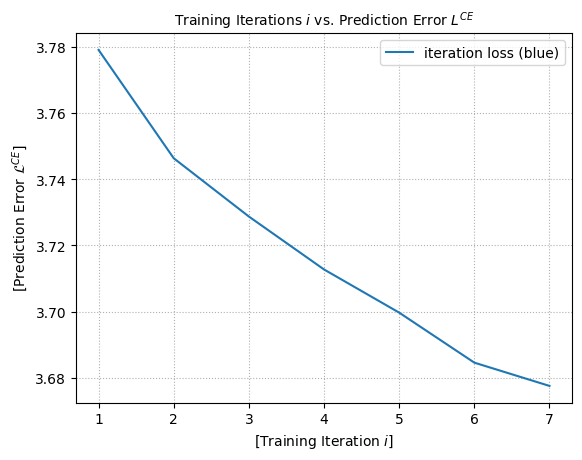

In [39]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot the training epochs vs. the epochs' classification error
ax.plot(np.array(range(1, len(train_iteration_losses)+1)), train_iteration_losses, label='iteration loss (blue)')

# add axis legends
ax.set_xlabel("[Training Iteration $i$]", fontsize=10)
ax.set_ylabel("[Prediction Error $\mathcal{L}^{CE}$]", fontsize=10)

# set plot legend
plt.legend(loc="upper right", numpoints=1, fancybox=True)

# add plot title
plt.title('Training Iterations $i$ vs. Prediction Error $L^{CE}$', fontsize=10);

Okay, fantastic. The training error converges nicely. We could definitely **train the network for more iterations** until the error converges. But let's stay with the 10,000 training iterations for now and continue with evaluating our trained model.

## 6. Neural Network Model Evaluation

Before evaluating our model, let's **load the best-performing model**. Remember that we stored a snapshot of the model after each training epoch to our local model directory. We will now load the last snapshot saved.

In [40]:
# init pre-trained model architecture
best_model = GPTNet(embed_dim=embed_dim, num_heads=num_heads, n_layer=n_layer, pos_len=pos_len)

# restore pre-trained model snapshot
best_model_name = 'https://raw.githubusercontent.com/HSG-AIML-Teaching/GSERM2024-Lab/master/lab_08/03_models/gptnet_model_iteration_900000.pth'

# read stored model from the remote location
model_bytes = urllib.request.urlopen(best_model_name)

# load model tensor from io.BytesIO object
model_buffer = io.BytesIO(model_bytes.read())

# load pre-trained models
best_model.load_state_dict(torch.load(model_buffer, map_location=torch.device('cpu')))

<All keys matched successfully>

Let's check if the model was loaded successfully:

In [41]:
# set model in evaluation mode
best_model.eval();

### 6.1 Model Text Generation

In this section, we will use our pre-trained GPT model to generate text. The model takes a prompt as input and **generates coherent and contextually relevant text** based on the patterns it learned during training.

Let's start by defining a method for text generation:

In [ ]:
def shakespeare_chat_gpt(model, prompt, max_new_tokens=300):

    # initialize generated text with the prompt
    generated_text = prompt
    
    # convert the prompt to tensor
    prompt_idx = torch.tensor([char_to_int[c] for c in prompt], dtype=torch.long).unsqueeze(0).to(device)

    # iterate over number of tokens
    for _ in range(max_new_tokens):
        
        # crop prompt, in case it's longer than pos_len
        prompt_idx_cond = prompt_idx[:, -model.pos_len:]
        
        # get the predictions
        logits, _ = model(prompt_idx_cond)
        
        # we only need the logits for the last token
        logits = logits[:, -1, :]
        
        # convert logits to probabilities
        probs = F.softmax(logits, dim=-1) # (B, C)
        
        # sample from the distribution
        predicted_token = torch.multinomial(probs, num_samples=1) # (B, 1)
        
        # append new token to the original prompt
        prompt_idx = torch.cat((prompt_idx, predicted_token), dim=1) # (B, T+1)
        
        # convert the token ID to string and add it to `generated_text`
        generated_text += int_to_char[predicted_token[0].item()]
        
        # stop generation if a specific stop token is reached
        if int_to_char[predicted_token[0].item()] == "#": 

            # stop generation
            break

    # return generated text
    return generated_text

To demonstrate the capabilities of our GPT model, let’s generate text with a few different humorous Shakespearean-style prompts.

**Example 1:** In this example, we have a humorous dialogue between a king and his jester. The king starts with an insult, and we let the model generate the jester’s witty response.

In [ ]:
# first example prompt
prompt = "KING:\n Thou art a veritable fool, my jester.\n JESTER:\n "
generated_text = shakespeare_chat_gpt(model=best_model, prompt=prompt, max_new_tokens=100)
print(generated_text)

**Example 2:** Here, we use a classic line from the witches in Shakespeare’s 'Macbeth' and let the model generate what the cauldron might say in response, adding a humorous twist.

In [ ]:
# second example prompt
prompt = "WITCH:\n Double, double toil and trouble.\n CAULDRON:\n "
generated_text = shakespeare_chat_gpt(model=best_model, prompt=prompt, max_new_tokens=100)
print(generated_text)

**Example 3:** This example features a conversation between a servant and a knight. The servant questions the knight’s eating habits, and the model generates the knight’s comical retort.

In [ ]:
# third example prompt
prompt = "SERVANT:\n Why dost thou eat so much?\n KNIGHT:\n "
generated_text = shakespeare_chat_gpt(model=best_model, prompt=prompt, max_new_tokens=100)
print(generated_text)

In summary, the generated text examples demonstrate the model’s ability to create contextually relevant and coherent continuations based on the input prompt. Here are a few key points to note:

- **Context:** The model generates text that fits the context and style of the original prompt.
- **Coherence:** The generated text maintains a logical flow, making it appear as if it were part of an actual dialogue.
- **Humor:** By choosing humorous prompts, we can see how the model handles creative funny continuations.

### 6.2 Model Attention Visualization

In this section, we will **visualize the attention mechanisms** of our trained GPT model. Attention visualization enables us understand which parts of the input sequence the model focuses on when generating each token in the output. This can provide insights into how the model processes and interprets the input text.

#### 6.2.1 Text Generation

First, we will generate text using our trained GPT model. We will start with an initial prompt and generate additional tokens step by step. During this process, we will also **extract and store the attention weights** for each generated token. We start with an initial prompt, **“To be “**, which the model will use as the basis for text generation. Next, we set the maximum number of new tokens to generate. In this case, we limit the model to generate up to 10 additional tokens. Following, we generate new tokens iteratively:

In [ ]:
# define the prompt for generation
prompt = "To be "

# set the maximum number of new tokens to generate
max_new_tokens = 10

# convert the prompt into tensor indices
prompt_idx = torch.tensor([char_to_int[c] for c in prompt], dtype=torch.long).unsqueeze(0).to(device)

# initialize an empty list to store attention weights
attention_weights = []

# init generated text with original prompt
generated_text = prompt

# generate tokens step by step
for _ in range(max_new_tokens):
    
    # crop the prompt if it's longer than the model's position length
    prompt_idx_cond = prompt_idx[:, -model.pos_len:]

    # get the predictions (logits) and attention scores from the model
    logits, attn_list = model(prompt_idx_cond)
    
    # we only need the logits for the last token
    logits = logits[:, -1, :]
    
    # convert logits to probabilities
    probs = F.softmax(logits, dim=-1) # (B, C)
    
    # sample from the distribution
    predicted_token = torch.multinomial(probs, num_samples=1) # (B, 1)
    
    # append new token to the original prompt
    prompt_idx = torch.cat((prompt_idx, predicted_token), dim=1) # (B, T+1)
    
    # convert the token ID to string and add it to `generated_text`
    generated_text += int_to_char[predicted_token[0].item()]

Let's review the text generated by our GPT model:

In [ ]:
generated_text

#### 6.2.2 Attention Heatmaps Visualization

Now, let's visualize and inspect the attention score heatmaps:

In [ ]:
# create grid of subplots for attention heads
fig, axes = plt.subplots(nrows=n_layer, ncols=num_heads, figsize=(30, 30))

# iterate over attention layers
for layer_idx in range(n_layer):

    # determine attention layer output
    attention_layer_out = attn_list[layer_idx]

    # remove the batch dimension
    attention_layer_out = attention_layer_out.squeeze(0)

    # iterate over attention heads
    for head_idx in range(num_heads):  # for each attention head

        # determine attention layer head
        attention = attention_layer_out[head_idx]

        # convert to numpy array
        attention = attention.detach().cpu().numpy()

        # determine subplot axis
        ax = axes[layer_idx, head_idx]

        # visualize attention scores
        ax.imshow(attention, cmap='gray', interpolation='nearest')  # Plot the attention in the current subplot

        # set subplot title
        ax.set_title(f"Attention Layer {layer_idx + 1} - Head {head_idx + 1}", fontsize=20)

        # set subplot x and y ticks
        ax.set_xticks(range(len(generated_text)-1), [*generated_text[:-1]], fontsize=15)
        ax.set_yticks(range(len(generated_text)-1), [*generated_text[1:]], fontsize=15)

        # set subplot x and y ticks location
        ax.xaxis.tick_top()
        ax.tick_params(axis='x', which='both', bottom=False, top=True)

# add a main title to the figure
fig.suptitle('Attention Visualization Across Layers and Heads', fontsize=34, y=1.00)

# adjust rect to make space for the title
plt.tight_layout(rect=[0, 0, 1, 1])

# Show the figure
plt.show()

In the heatmap, the rows represent the input tokens, and the columns represent the attention scores assigned to each token by the model. Brighter colors indicate higher attention scores. By examining the heatmap, we can gain insights into the model’s focus and the relationships it has learned between different tokens in the input sequence.

1. **Diagonal Dominance**: If the heatmap shows a strong diagonal pattern, it indicates that the model is primarily attending to the current token or nearby tokens, reflecting a local context focus.
2. **Long-Range Dependencies**: Attention patterns that extend beyond the diagonal indicate that the model is capturing long-range dependencies, which is crucial for understanding complex sequences.

By visualizing and interpreting the attention weights, we can better understand the inner workings of our GPT model and improve its performance and interpretability.

#### 6.2.3 Model Perplexity Evaluation

Perplexity is a crucial metric used to **evaluate the performance of a language model**. It measures how well the model predicts a given sequence of words. Essentially, perplexity **assesses the degree of "surprise" the model has when encountering the sequence**. A lower perplexity indicates a better-performing model, as it suggests that the model is less surprised by the given sequence, implying better predictions.

The formula to compute perplexity for a single sequence is:

$$\text{Perplexity} = \exp \left( -\frac{1}{N} \sum_{i=1}^{N} \log P(w_i \mid w_1, w_2, \ldots, w_{i-1}) \right)$$

Where \( N \) is the number of words in the sequence. To understand perplexity, consider the following example sequence of words: "I am studying machine learning". The probabilities assigned by the model to each word in the context of the previous words might be as follows:

- $P(\text{I}) = 0.1$
- $P(\text{am} \mid \text{I}) = 0.5$
- $P(\text{studying} \mid \text{I am}) = 0.2$
- $P(\text{machine} \mid \text{I am studying}) = 0.9$
- $P(\text{learning} \mid \text{I am studying machine}) = 0.7$

For the example sequence, the perplexity would be:

$\text{Perplexity}(\text{I am studying machine learning}) = (0.1 \times 0.5 \times 0.2 \times 0.9 \times 0.7)^{-\frac{1}{5}} \approx 2.76$

A perplexity of 2.76 indicates that, on average, the model is about **2.76 times more "surprised"** than it would be if it predicted the sequence perfectly (indicating the model assigns the highest possible probability of 1.0 to each word in the sequence given the context of the preceding words). **A perplexity of 1.0 indicates that there is no “surprise” at all—the model predicted each word with absolute certainty**. In real-world scenarios, no model achieves perfect prediction, and thus, the perplexity is always greater than 1.0. Lower perplexity values indicate better performance, meaning the model’s predictions are closer to the actual occurrences in the sequence, showing that the model is less surprised by the actual sequence of words.

Below is an example of how to evaluate the model perplexity using the evaluation data:

In [ ]:
# set the model to evaluation mode
model.eval() 

# init perplexity log probabilities
total_log_prob = 0

# init perplexity number of words
num_words = 0

# init eval dataloader
eval_dataloader = DataLoader(eval_dataset, batch_size=mini_batch_size, shuffle=False, drop_last=True)

# disable gradient calculation
with torch.no_grad():

    # iterate over dataloader
    for inputs, targets in tqdm(eval_dataloader):
    
        # push inputs and targets to compute device
        inputs, targets = inputs.to(device), targets.to(device)
    
        # determine logits
        logits, _ = model(inputs, targets)
    
        # get the shape of logits (B: batch size, T: sequence length, C: number of classes/vocabulary size)
        B, T, C = logits.shape
    
        # reshape logits for loss calculation, flattening the batch and sequence dimensions
        logits = logits.view(B * T, C)
    
        # reshape targets
        targets = targets.view(B * T)
        
        # apply softmax to get probabilities
        probs = F.softmax(logits, dim=-1)  # (B, C)
    
        # calculate perplexity
        probs = probs.detach().cpu().numpy()
        sentence_log_prob = sum(math.log2(prob[t]) for prob, t in zip(probs, targets.reshape(-1)))
        
        # add to the total log probability and the number of words
        total_log_prob += sentence_log_prob
        num_words += probs.shape[0]
    
    # calculate the average log probability
    average_log_prob = total_log_prob / num_words

# calculate perplexity
perplexity = 2 ** (-average_log_prob)

Finally print the model perplexity:

In [ ]:
print(f'GPT Model Perplexity: {perplexity}')

## 7. Lab Summary

In this lab, you successfully accomplished the following key learnings:

> 1. **Introduction to GPT Models:** Gained a comprehensive understanding of Generative Pre-trained Transformer (GPT) models, focusing on their architecture and unique ability to capture long-range dependencies in sequential data.
> 2. **Hands-on Implementation:** Developed practical skills in implementing a GPT model using the PyTorch library, applying it to the Tiny Shakespeare dataset to learn the intricacies of training deep learning models for natural language processing tasks.
> 3. **Text Generation and Evaluation:** Learned how to generate new text based on trained models and evaluated the model's performance, enhancing your capability to work on real-world text generation projects.
> 4. **Visualization of Attention Mechanisms:** Acquired expertise in visualizing attention mechanisms within the GPT model, providing deeper insights into how the model processes and generates text, which is crucial for understanding model interpretability.

This lab provided insights into the application and implementation of GPT models, equipping you with essential tools and techniques for effective model building, evaluation, and application in natural language processing. These skills are invaluable for building and training your own GPT models.